In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors, QED, Crippen, rdMolDescriptors
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define property calculation
def calc_props(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        'LogP': Crippen.MolLogP(mol),
        'MW': Descriptors.MolWt(mol),
        'HBD': Descriptors.NumHDonors(mol),
        'HBA': Descriptors.NumHAcceptors(mol),
        'PSA': rdMolDescriptors.CalcTPSA(mol),
        'ROTB': Descriptors.NumRotatableBonds(mol),
        'FSP3': rdMolDescriptors.CalcFractionCSP3(mol),
        'QED': QED.qed(mol),
        'HeavyAtomCount': Descriptors.HeavyAtomCount(mol)
    }


In [2]:
properties = ['LogP', 'MW', 'HBD', 'HBA', 'PSA', 'ROTB', 'FSP3', 'QED', 'HeavyAtomCount']

In [3]:
df_enamine = pd.read_csv('final_products_Enamine.csv')
df_spirodrimane = pd.read_csv('Spirodrimane_monomer.csv')

df_enamine['Source'] = 'Enamine'
df_spirodrimane['Source'] = 'Spirodrimane'

df_all = pd.concat([df_enamine, df_spirodrimane], ignore_index=True)
df_all['Properties'] = df_all['SMILES'].apply(calc_props)
df_all = df_all.dropna(subset=['Properties'])

# Expand property columns
props_df = pd.DataFrame(df_all['Properties'].tolist())
df_all = pd.concat([df_all, props_df], axis=1)


In [4]:
len(df_all)

4291

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np

# Generate Morgan fingerprints (with error handling)
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Apply and filter
df_all['Fingerprint'] = df_all['SMILES'].apply(get_fingerprint)
df_all = df_all[df_all['Fingerprint'].notnull()].reset_index(drop=True)

# Convert to 2D numpy array
fp_array = np.stack(df_all['Fingerprint'].values)


In [6]:
len(fp_array)

4291

In [7]:
from sklearn.manifold import TSNE

tsne_result = TSNE(
    n_components=2,
    perplexity=30,         # try 30 for better separation
    learning_rate=200,     # more stable embedding
    n_iter=1000,
    init='pca',            # more consistent start
    random_state=42
).fit_transform(fp_array)

df_all['tSNE-1'] = tsne_result[:, 0]
df_all['tSNE-2'] = tsne_result[:, 1]


In [8]:
natural = df_all[df_all['Source'] == 'Spirodrimane']
enumerated = df_all[df_all['Source'] == 'Enamine']


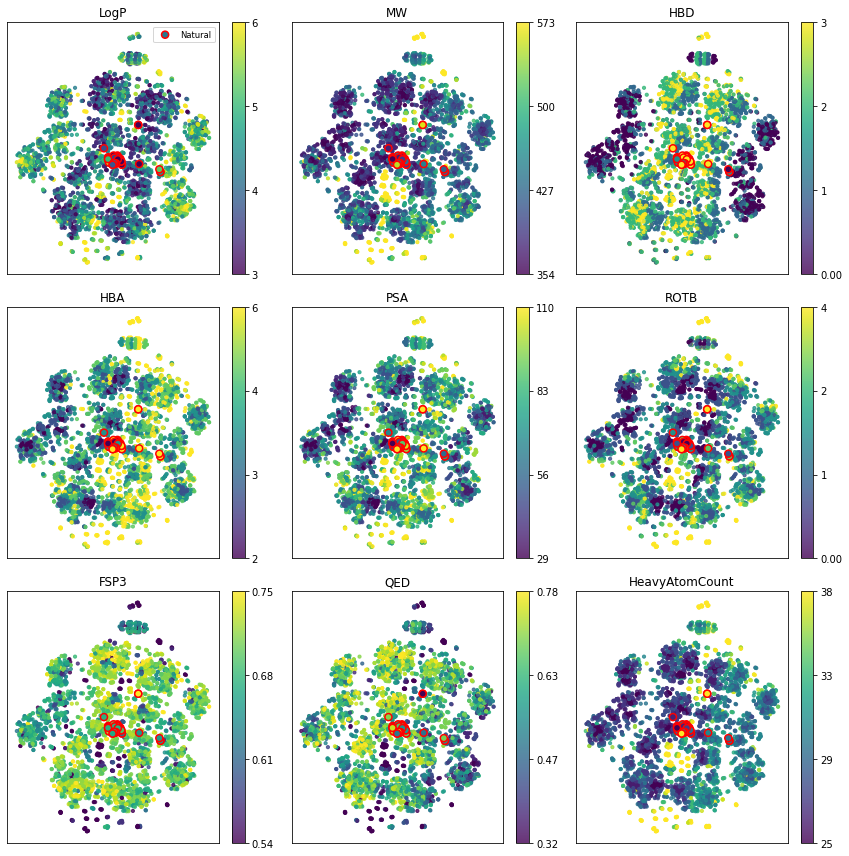

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Create 3×3 subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, prop in enumerate(properties):
    ax = axes[i]

    # Extract and clip property values for Enamine
    enamine = df_all[df_all['Source'] == 'Enamine']
    values = enamine[prop].values
    lower = np.percentile(values, 5)
    upper = np.percentile(values, 95)
    clipped = np.clip(values, lower, upper)

    # Plot Enamine compounds with color mapping
    sc = ax.scatter(
        enamine['tSNE-1'], enamine['tSNE-2'],
        c=clipped, cmap='viridis', s=10, alpha=0.8
    )

    # Plot Spirodrimane compounds with same color scale but red edge
    spiro = df_all[df_all['Source'] == 'Spirodrimane']
    spiro_values = np.clip(spiro[prop].values, lower, upper)

    ax.scatter(
        spiro['tSNE-1'], spiro['tSNE-2'],
        c=spiro_values, cmap='viridis', edgecolor='red',
        linewidth=1.5, s=50, alpha=1.0, label='Natural', zorder=3
    )

    # Axis and title
    ax.set_title(prop)
    ax.set_xticks([])
    ax.set_yticks([])

    # Colorbar with customized tick formatting
    cbar = fig.colorbar(sc, ax=ax)
    ticks = np.linspace(lower, upper, 4)

    def format_tick(x, pos):
        return f"{x:.2f}" if x < 1 else f"{int(x)}"
    cbar.set_ticks(ticks)
    cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_tick))

    if i == 0:
        ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, dash_table
from jupyter_dash import JupyterDash

# Load your dataframe (update the path if needed)

color_prop = 'QED'  # Property for coloring

# Create figure
fig = px.scatter(
    df_all,
    x='tSNE-1',
    y='tSNE-2',
    color=color_prop,
    hover_data=['SMILES'],
    title=f"t-SNE Plot Colored by {color_prop}"
)

# Use JupyterDash for inline Dash app
app = JupyterDash(__name__)
app.layout = html.Div([
    dcc.Graph(id='scatter-plot', figure=fig, style={'height': '800px'}),
    html.Div(id='selected-output')
])

@app.callback(
    Output('selected-output', 'children'),
    Input('scatter-plot', 'selectedData')
)
def display_selected_points(selectedData):
    if selectedData is None or not selectedData.get("points"):
        return html.P("Click or box-select a point to view SMILES and properties.")

    selected_smiles = [point["customdata"][0] for point in selectedData["points"]]
    selected_df = df_all[df_all["SMILES"].isin(selected_smiles)]

    return dash_table.DataTable(
        columns=[{"name": i, "id": i} for i in selected_df.columns],
        data=selected_df.to_dict('records'),
        page_size=10,
        style_table={'overflowX': 'auto'},
        style_cell={'textAlign': 'left', 'padding': '5px'},
        style_header={'backgroundColor': 'lightgrey', 'fontWeight': 'bold'}
    )

# Run in notebook
app.run_server(mode='inline', debug=True)


In [11]:
df_all.to_csv('all_product_info.csv')